In [2]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES
from src.models import Net, ConvBlock, LinearBlock
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold
from src.nn_train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.sklearn_train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [2]:
# Load data
datadir = '../data/partitioned_traindata/'
cedar = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
cedar_10fold = pd.read_csv(datadir+'cedar_10fold.csv')
cedar_hp_10fold_low = pd.read_csv(datadir+'cedar_hp_mixed_10fold.csv')
cedar_hp_10fold_uni = pd.read_csv(datadir+'cedar_hp_mixed_rank120_10fold.csv')
cedar_viral = pd.read_csv(datadir+'cedar_viral_10fold.csv')

# dataset_10fold = pipeline_stratified_kfold('../out/cedar_peps_hobohm_0.925.pep', cedar, k=10, shuffle=True)
sample = cedar_10fold.sample(10)[['Peptide', 'HLA', 'trueHLA_EL_rank', 'agg_label', 'len']]
# other data/stuff
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')
ics_none = None
prime_dataset = pd.read_excel(datadir+'PRIME_dataset.xlsx', skiprows=2, comment='#')
prime_dataset.head(3)

Mutant Allele  MixMHCpred  NetMHCpanEL  NetMHCpanBA  NetMHCpanBA_Kd  \
0   VMLQAPLFT  A0201         7.0        2.391        2.193          356.05   
1   MLIVETAVM  A0201         7.0        1.936        1.610          206.86   
2  MLIVETAVML  A0201         8.0        1.256        0.586           47.33   

   NetMHCstabpan  NetMHCstabpan_T12  MHCflurry  HLAthena  NetChop    TAP  \
0            8.5               0.54     0.8535   8.40544  0.03431 -0.350   
1            9.0               0.53     1.3350   8.40110  0.90141  0.301   
2            3.0               1.39     0.8120   3.18349  0.96017  0.951   

      IEDB  Foreignness  WT_peptide  NetMHCpanEL_WT  NetMHCpanBA_Kd_WT  \
0 -0.03346     0.000000   DMLQAPLFT          12.165           10345.08   
1  0.27592     0.000000   MLIVETADM           3.475             569.10   
2  0.18911     0.000177  MLIVETADML           2.789             140.70   

   ratio_%rank  ratio_Kd  DisToSelf DisToSelf_peptide  Immunogenicity  \
0     1.626851  0.034417          9         DMLQAPLFT               0   
1     0.584970  0.363486          9         MLIVETADM               0   
2     0.797751  0.336389          9        MLIVETADML               0   

  StudyOrigin  PRIME  
0     Bobisse    0.0  
1     Bobisse    0.0  
2     Bobisse    0.0

In [8]:
kcv_tune_sklearn(cedar_10fold, XGBClassifier(tree_method='gpu_hist'), ics_shannon, encoding_kwargs=None, hyperparams=dict(n_estimators = [250], max_depth = 5, reg_lambda=1e-5, reg_alpha=1e-5))

TypeError: Parameter grid value is not iterable (key='n_estimators', value=250)

# dataset checks

In [6]:
viral = pd.read_csv('../data/heli_viral', sep ='\s')
print(viral.columns)
viral = viral.rename(columns = {'peptide_length':'len'})
# [['id', 'Icore', 'allele', 'Core', 'Rnk_EL', 'target', 'target_bin_2', 'target_qual_corrected', 'len', 'allele_mod']]
# Recover the peptide sequence
viral['Peptide']= viral.apply(lambda x: x['prot_sequence'][x['peptide_start']:x['peptide_stop']+1], axis=1)
# Quick checks that it makes sense
viral[['Peptide', 'Icore', 'Core']]

Index(['id', 'Icore', 'allele', 'prot_sequence', 'Core', 'Of', 'Gp', 'Gl',
       'Ip', 'Il', 'Rnk_EL', 'uniprot_id', 'number_papers_positive',
       'number_papers_negative', 'subj_tested', 'subj_responded', 'target',
       'target_bin_2', 'target_qual_corrected', 'peptide_length',
       'peptide_start', 'peptide_stop', 'non_aa_pep', 'non_aa_prot',
       'allele_mod', 'training'],
      dtype='object')


Peptide       Icore       Core
0      TVTSTPVQGR  TVTSTPVQGR  TVTSTPVQR
1      TVYPPSSTAK  TVYPPSSTAK  TVYPPSSTK
2      AEWPTFNVGW  AEWPTFNVGW  AEWPTNVGW
3       ILDSFDPLV   ILDSFDPLV  ILDSFDPLV
4      RLIVFPDLGV  RLIVFPDLGV  RLIVFPLGV
...           ...         ...        ...
16798   LLHERLDEF   LLHERLDEF  LLHERLDEF
16799   LFITSTHVI   LFITSTHVI  LFITSTHVI
16800   FTISDSATF   FTISDSATF  FTISDSATF
16801   YLQQRTFLL   YLQQRTFLL  YLQQRTFLL
16802   YLKPRTFML   YLKPRTFML  YLKPRTFML

[16803 rows x 3 columns]

In [4]:
mixed=pd.read_csv('../data/script_traindata/cedar_hp_mixed_10fold.csv')

In [5]:
ct=mixed.groupby('agg_label')['Peptide'].count()
ct[1]/ct[0]

0.10072497300632423

In [95]:
# Read and concat
cedar['dataset'] = 'cedar'
hp_120 = pd.read_csv('../output_xls/subsampled/humanprot_sub_N55_seed13_cons_True_3_1575779149_scored.txt').drop(columns=['wt'])
hp_120['len'] = hp_520.Peptide.apply(len)
hp_120['agg_label'] = 0
hp_120['percentage_pos'] = 0
hp_120['dataset'] = 'hp'
hp_120['total_count'] = 3
cols = ['Peptide', 'HLA', 'dataset', 'total_count', 'percentage_pos', 'agg_label', 'len', 'trueHLA_EL_rank', 'core', 'icore', 'BA_score', 'BA_rank']
cedar_mixed_hp120 = pd.concat([cedar[cols], hp_120.rename(columns={'EL_Rank':'trueHLA_EL_rank',
                                                                   'BA-score':'BA_score',
                                                                   'BA_Rank':'BA_rank'})[cols]]).reset_index(drop=True)

In [83]:
# Save for kerndist
cedar_mixed_hp120['Peptide'].to_csv('../../../kern_dist/data/cedar_mixed_hp120.pep', index=False, header=False)

In [97]:
cedar_mixed_hp120_hobohm = pipeline_stratified_kfold('../../../kern_dist/out/cedar_mixed_hp120.pep_0.9.pep', cedar_mixed_hp120,
                                                     k=10)

In [100]:
cedar_mixed_hp120_hobohm.to_csv('../data/script_traindata/cedar_hp_mixed_rank120_10fold.csv', index=False)

# Peptide AA prop values

In [9]:
import peptides
from datetime import datetime as dt
from src.data_processing import get_aa_properties

start = dt.now()
vals = get_aa_properties(dataset_10fold)[0][['Peptide', 'HLA', 'agg_label', 'fold','len', 'trueHLA_EL_rank',
 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65',
 'hydrophobicity', 'isoelectric_point', 'PD2', 'VHSE1', 'VHSE2', 'VHSE3',
 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']]
end = dt.now()
elapsed = divmod((end-start).seconds, 60)
print(f'Time elapsed: {elapsed[0]}m {elapsed[1]}s or {(end-start).microseconds} ms')

Time elapsed: 0m 2s or 791013 ms


In [10]:
# Checking distributions 
from scipy.stats import mannwhitneyu, ttest_ind

def plot_aaprops(vals, label_column='agg_label', rank_column='trueHLA_EL_rank', title = 'Different AA properties on CEDAR\nONE-SIDED MW-U and Welch tests'):
    pal = sns.color_palette('hsv', n_colors = 13)
    sns.set_palette([pal[-4], pal[-1]])
    f,a = plt.subplots(8,2, figsize = (10, 32))
    ax = a.ravel()
    
    hue = [label_column]
    for i,key in enumerate([rank_column, 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65', 'hydrophobicity', 
                            'isoelectric_point', 'PD2',  'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']):
        gb=vals.groupby(label_column)[key].agg(['mean', 'median'])
        med_0 = gb.loc[0,'median']
        med_1 = gb.loc[1, 'median']
        sns.histplot(data = vals, x = key, hue=label_column, alpha = 0.4, kde=True, ax=ax[i], legend=True, hue_order=[0,1])
        # Reset max ylim
        upper = ax[i].get_ylim()[1]
        ax[i].set_ylim([0, upper* 1.15])
        
        # Mann Whitney U test
        pos, neg = vals.query(f'{label_column}==1')[key].values, vals.query(f'{label_column}==0')[key].values
        
        alt_t = 'greater' if pos.mean()>neg.mean() else 'less'
        """
        ‘less’: the distribution underlying x is stochastically less than the distribution underlying y, i.e. F(u) > G(u) for all u.
        """
        alt_mw = 'less' if pos.mean() < neg.mean() else 'greater'
        
        _, pval_mw = mannwhitneyu(pos, neg, alternative=alt_mw)
        _, pval_t = ttest_ind(pos,neg, equal_var = False, alternative=alt_t)
        
        
        sig_mw = f'ns; p={pval_mw:.3f}' if pval_mw>0.05 else f'*, p={pval_mw:.2e}'
        sig_t = f'ns; p={pval_t:.3f}' if pval_t>0.05 else f'*, p={pval_t:.2e}'
        ax[i].set_title(f'MW-U: {sig_mw}; Welch test: {sig_t}')
        # Reset ax if HLA rank
        if key == rank_column:
            ax[i].set_xlim([0,20])
            
        # Drawing axvlines
        ax[i].axvline(x=med_0, label = 'Median 0', ls = '--', lw = '.65', color='b' )
        ax[i].axvline(x=med_1, label = 'Median 1', ls = '--', lw = '.65', color='m')
        # Get the fucking rectangles from sns plots
        legend = ax[i].get_legend()
        handles = legend.legendHandles
        # Combine to the fucking lines from plt/ax plots
        handles.extend(ax[i].get_legend_handles_labels()[0])
        # Set the labels manually like a dog
        labels = ["Label = 0", "Label = 1", "Median 0", "Median 1"]
        # Reset the legend manually like a dog
        ax[i].legend(handles = handles, labels = labels)
    f.suptitle(f'{title}', fontweight= 'semibold',fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.955)

In [11]:
start = dt.now()
vals_viral = get_aa_properties(viral, seq_col = 'Core')[0][['Core', 'Rnk_EL','allele', 'target', 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65', 'hydrophobicity', 'isoelectric_point', 'PD2', 'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']]
end = dt.now()
elapsed = divmod((end-start).seconds, 60)
print(f'Elapsed: {elapsed[0]} minutes {elapsed[1]} seconds.')


Elapsed: 0 minutes 13 seconds.


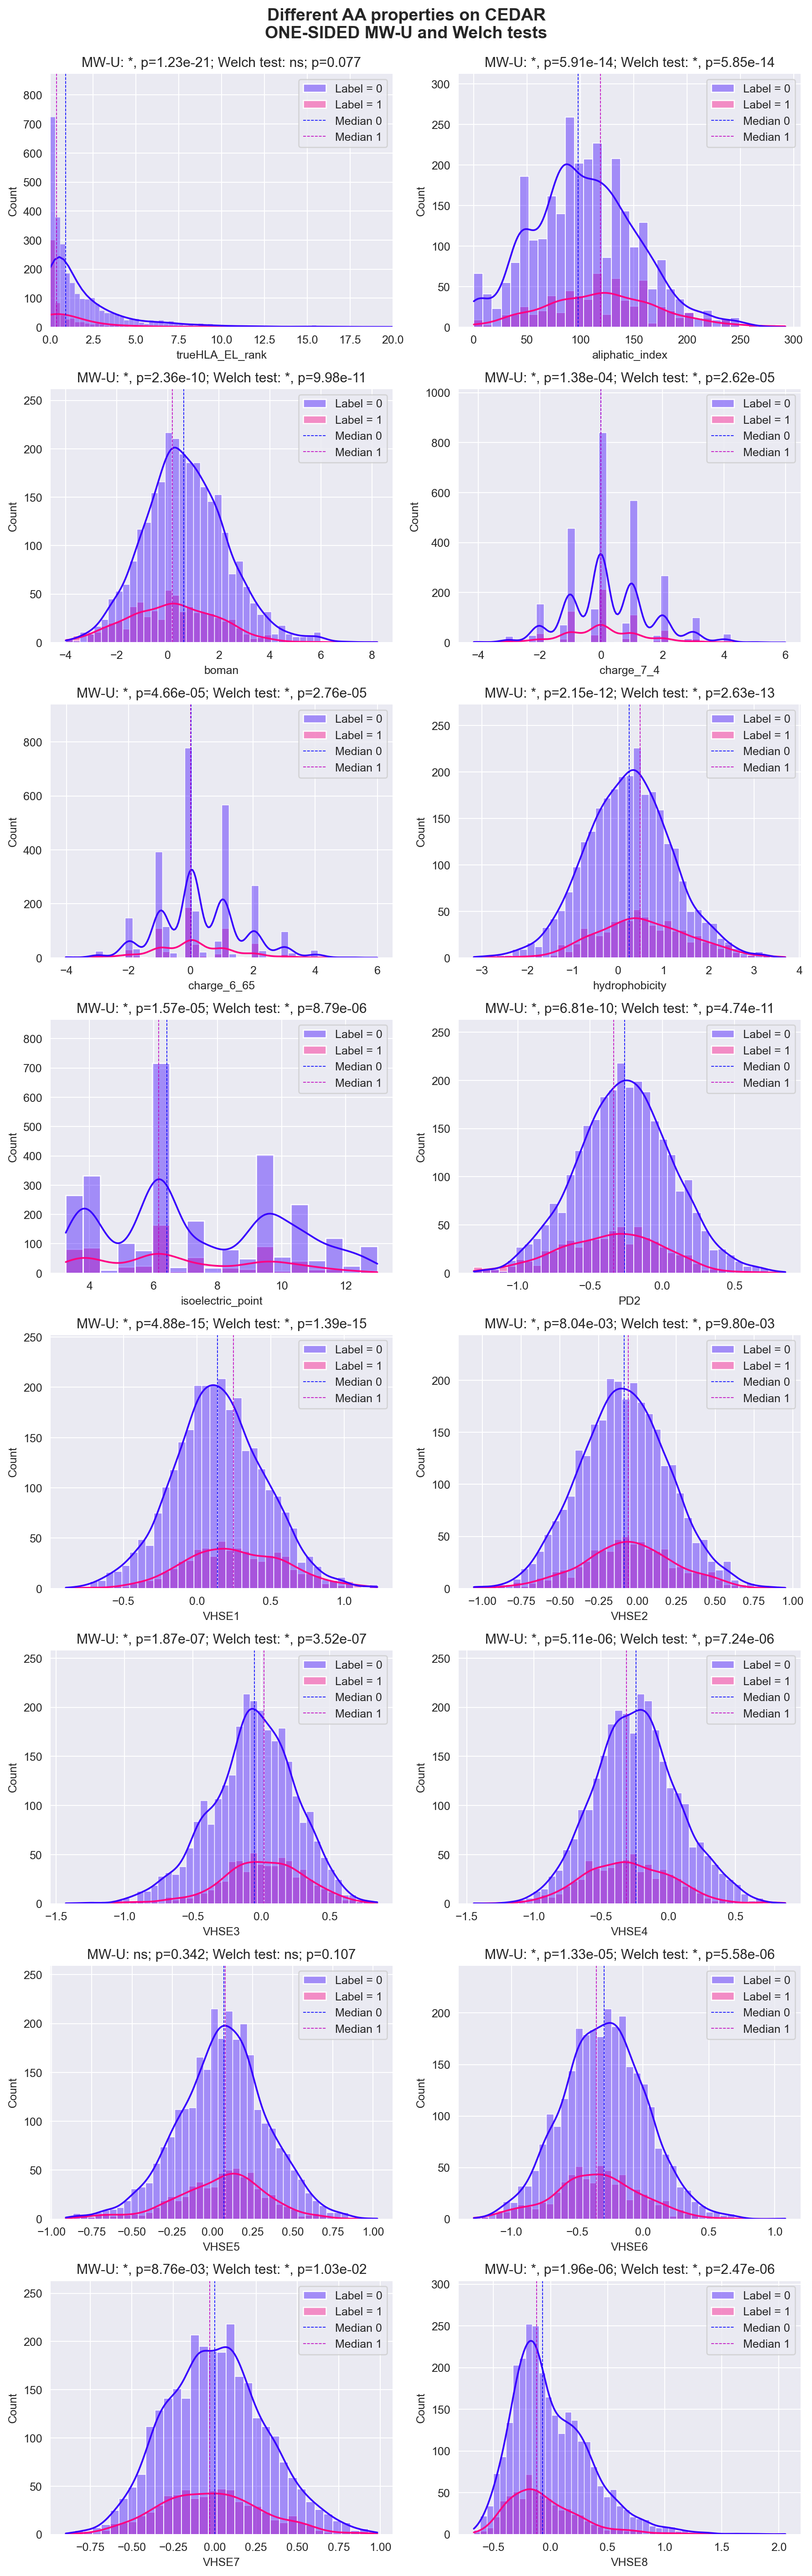

In [12]:
plot_aaprops(vals)

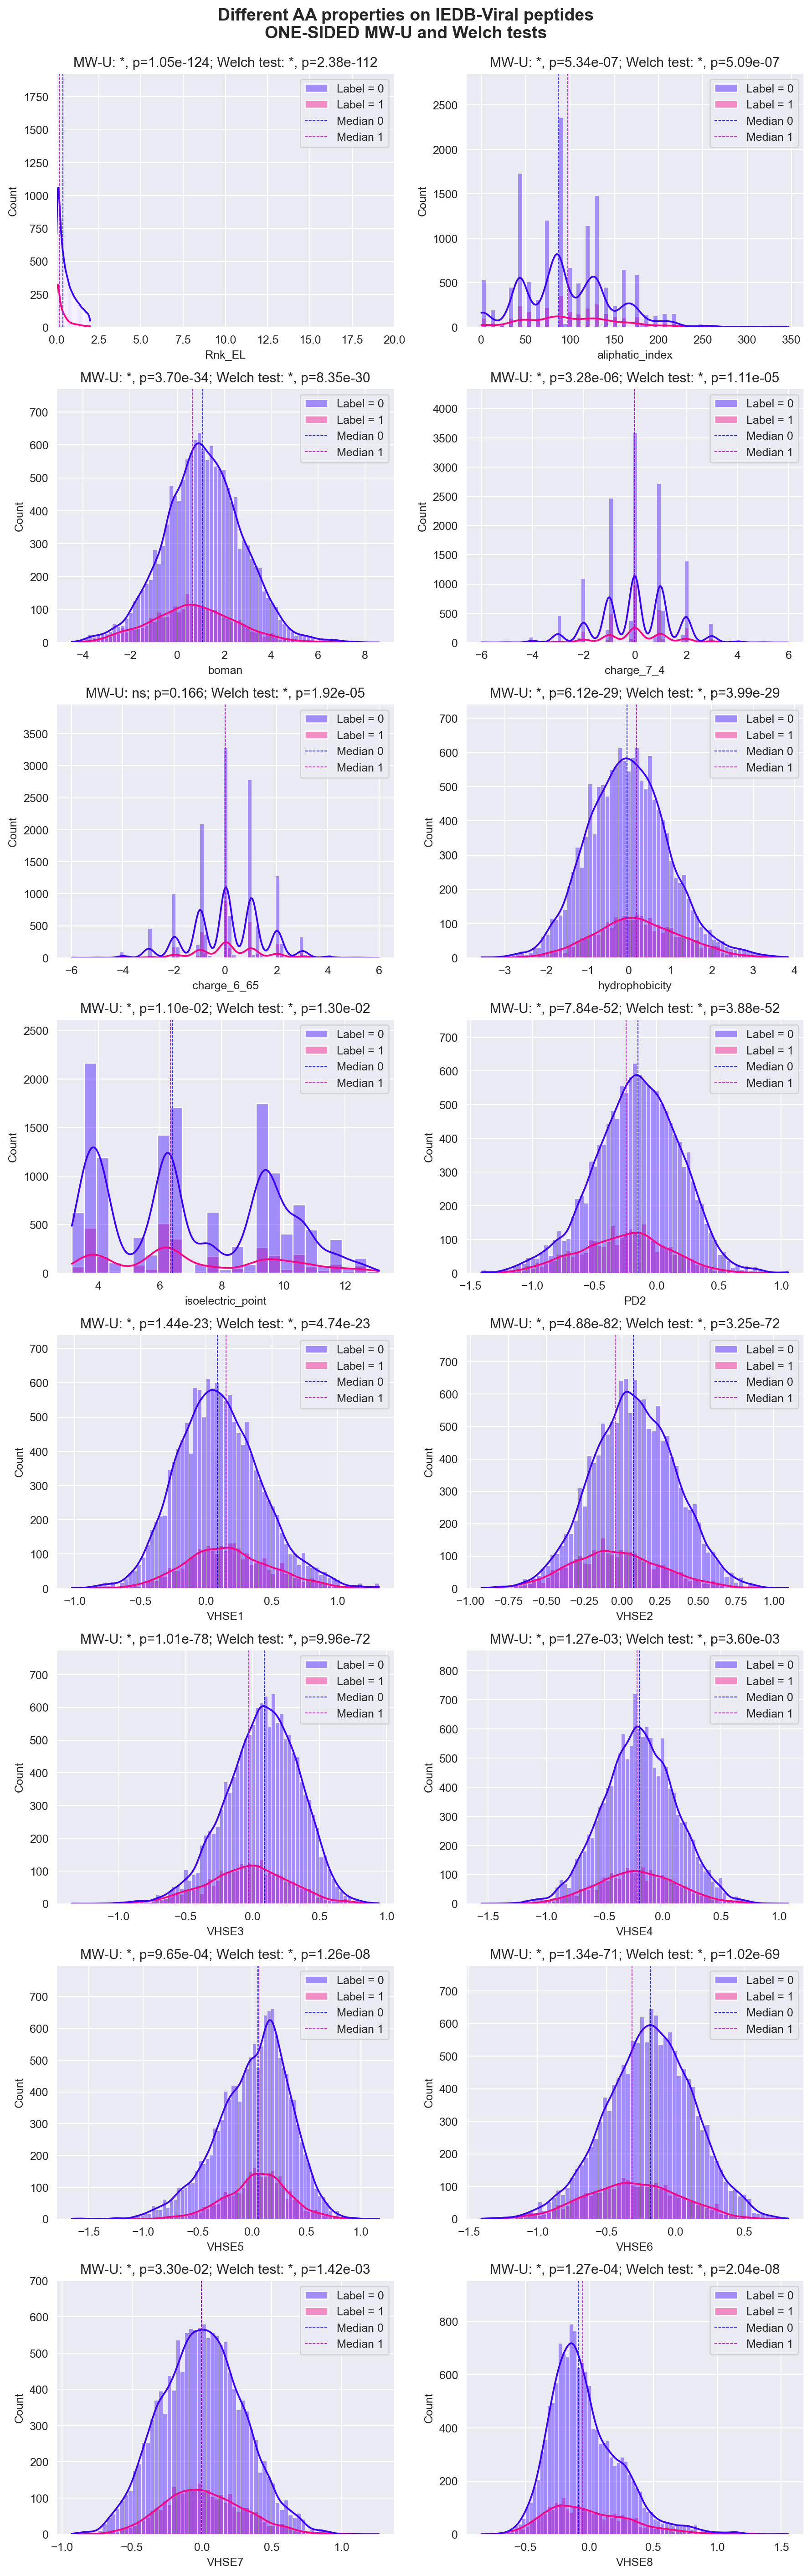

In [13]:
plot_aaprops(vals_viral, label_column='target', rank_column = 'Rnk_EL', title = 'Different AA properties on IEDB-Viral peptides\nONE-SIDED MW-U and Welch tests')

# Kwargs stuff

In [6]:
from src.data_processing import BL62FREQ_VALUES, BL62_VALUES, batch_compute_frequency, encode_batch_weighted, encode_batch, get_dataset, standardize
# pass encoding_kwarg dict in nested_kcv_train fct, and pass it as **kwargs in the get_dataset call within the function

kwargs = {'max_len':12,
          'encoding':'blosum',
          'blosum_matrix':BL62FREQ_VALUES,
          'mask':False,
          'add_rank':True,
          'add_aaprop':True}
x,y = get_dataset(sample, ics_shannon, **kwargs)
x1,y1 = get_dataset(sample, ics_shannon, encoding='blosum', blosum_matrix=BL62FREQ_VALUES, add_aaprop=False, add_rank=False)
xv,yv = get_dataset(dataset_10fold.sample(5), ics_shannon, **kwargs)

[0.08771972 0.04159473 0.03273592 0.02829032 0.03218401 0.07464311
 0.04152333 0.07766024 0.03012701 0.04919218 0.0588269  0.0627955
 0.04889473 0.02878163 0.02966183 0.04866522 0.04200821 0.02207745
 0.02881325 0.06143174] (10, 20)
(10, 1)
(10, 21)
(10, 15)
(10, 36)
[0.08771972 0.04159473 0.03273592 0.02829032 0.03218401 0.07464311
 0.04152333 0.07766024 0.03012701 0.04919218 0.0588269  0.0627955
 0.04889473 0.02878163 0.02966183 0.04866522 0.04200821 0.02207745
 0.02881325 0.06143174] (10, 20)
[0.02671135 0.02098486 0.04763922 0.02151749 0.0603372  0.03467344
 0.02323461 0.01808391 0.02259019 0.0293188  0.02558467 0.02455281
 0.02696487 0.08416983 0.05863686 0.03994723 0.02930952 0.06501223
 0.03933642 0.03601344] (5, 20)
(5, 1)
(5, 21)
(5, 15)
(5, 36)


In [10]:
x_copy = x.copy()

In [11]:
x_copy, xv = standardize(x_copy, xv)

## hyperparams grid

In [15]:
hp = {'a': [1,2,3],
      'b': [4,5,6],
      'c': [7,8,9]}
for k,v in hp.items():
    print(k,v)

a [1, 2, 3]
b [4, 5, 6]
c [7, 8, 9]


In [21]:
from sklearn.model_selection import ParameterGrid
import random 
for k in list(ParameterGrid(hp)):
    k['result_value'] = random.randint(0, 200)

# mean rocs

In [65]:
pd.DataFrame(list(ParameterGrid(hp)))

a  b  c
0   1  4  7
1   1  4  8
2   1  4  9
3   1  5  7
4   1  5  8
5   1  5  9
6   1  6  7
7   1  6  8
8   1  6  9
9   2  4  7
10  2  4  8
11  2  4  9
12  2  5  7
13  2  5  8
14  2  5  9
15  2  6  7
16  2  6  8
17  2  6  9
18  3  4  7
19  3  4  8
20  3  4  9
21  3  5  7
22  3  5  8
23  3  5  9
24  3  6  7
25  3  6  8
26  3  6  9

In [56]:
from src.metrics import get_mean_roc_curve
d = {}
for fold in range(8):
    d[fold] = {}
    d[fold]['valid'] = {}
    n = np.random.randint(500, 550)
    x_curve = np.arange(0,n)
    y_curve = np.random.rand(n) * np.arange(0,n)
    d[fold]['valid']['roc_curve'] = [x_curve, y_curve]
    print(n)

543
506
526
504
509
517
522
527


In [58]:
x, y, lower, upper = get_mean_roc_curve(d, extra_key='valid')

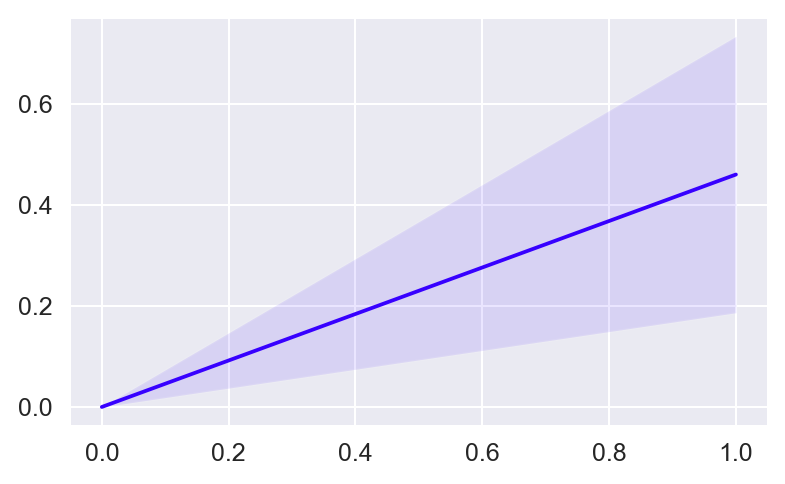

In [62]:
f,ax = plt.subplots(1,1, figsize=(5,3))
sns.lineplot(x=x, y=y, ax=ax)
ax.fill_between(x, lower, upper, alpha=0.1)

In [45]:
np.stack([np.random.rand(100, 3) for _ in range(5)]).mean(axis=0).shape

(100, 3)

In [28]:
pd.DataFrame(k, index=[0])

a  b  c  result_value
0  3  6  9            39

# Wrapper with encoding kwargs stuff

In [7]:
md = LinearBlock(1,2)
# Use this to do the switch in train wrapper
issubclass(md.__class__, nn.Module)

True

In [8]:
# Wrapper stuff : 
def kcv_wrapper(train_dataset,dataset_name, model_type, weighting, weighting_name, add_rank):
    """
    TODO: HERE BASICALLY MERGE ALL THE DIFFERENT ENCODING ARGS INTO A DICT, AND PASS IT AS ENCODINGKWARGS TO NESTED_KCV_TRAIN!
    """
    # dataset_name = f'{train_dataset=}'.split('=')[0]
    # print(dataset_name)
    ic_name = f'{weighting=}'.split('=')[0]
    rank_name = f'EL_{add_rank}'
    model_name = model_type.__name__

    if model_name == 'LinearBlock':
        results = np.random.randint(100,200, size=[5]) # HERE REPLACE WITH RESULTS = KCV SOME SHIT
    else:
        results = np.random.randint(0,5, size=[5])
    outname = model_name+rank_name+weighting_name+dataset_name
    return outname, results

results = []
# Maybe keep the kwargs as loop, and parallelize models & datasets instead?
# Not the most efficient but more readable / easy to write in terms of arguments because of 
for train_dataset, dataset_name in zip([dataset_5fold, dataset_10fold], ['cedar', 'cedar_hp']):
    for model in [RandomForestClassifier, XGBClassifier, LogisticRegression, LinearBlock]:
        kcv_wrapper_ = partial(kcv_wrapper, train_dataset = train_dataset, dataset_name = dataset_name, model_type = model)
        output = Parallel(n_jobs=4)(delayed(kcv_wrapper_)(weighting=weighting, weighting_name=weighting_name, add_rank=add_rank) for (weighting, weighting_name), add_rank in \
                                    product(zip([ics_shannon, ics_kl, ics_none], ['shannon','kl','none']), [True, False]))
        results.extend(output)
        

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
d = {'a':1, 'b':2, 'c':3}
name = '_'.join([f'{k}{v}' for k,v in d.items() if k!='b'])
name

In [ ]:
encoding_kwargs = {'max_len':12,
                   'encoding':1,
                   'blosum_matrix':2,
                   'mask': 3,
                   'add_rank': 4,
                   'add_aaprop': 5,
                   'remove_pep':6,
                   'standardize': 7}
outname = {'model':'rf'}
# Save the parameter name as a massive string to tag the output.
outname.update({k:v for k,v in encoding_kwargs.items() if k!='blosum_matrix'})
'_'.join([f"{k.replace('add_','')}{v}" for k,v in outname.items()])

In [ ]:
import xgboost
xgboost.XGBClassifier().__class__.__name__

# DEFINE LOOPS AND COMBINATIONS

## test of mega product:

Flattening + Running in parallel & re-get the proper params into the right place

In [263]:
from itertools import product

In [272]:
from itertools import product
from src.utils import flatten_product
encode_blosum_zip = zip(['onehot', 'blosum', 'blosum'], [None, 1, 2])
# Weighting zip
ics_mask_zip = zip([1, 2, 3, 4], ['Shannon', 'KL', 'None', 'Mask'],
                            [False, False, False, True])
# True/False zips for add_rank, add_aaprop, remove_pep
features_zip = zip([True, True, True, False, False, False],
                   [True, True, False, True, True, False],
                   [False, True, False, False, True, False])
 
# Lone conditions (to be producted so not zipped)
train_datasets = [1, 2, 3, 4]
standardize_ = [True, False]

conditions = product(train_datasets, 
                     product(encode_blosum_zip, 
                             product(ics_mask_zip, 
                                     product(features_zip, 
                                             product(standardize_)))))

# train_dataset, encoding, blosum matrix, ics dict, ics name, mask, add rank, add prop, remove pep, standardize
conditions = list(list(flatten_product(x)) for x in conditions)
len(conditions), conditions

(576,
 [[1, 'onehot', None, 1, 'Shannon', False, True, True, False, True],
  [1, 'onehot', None, 1, 'Shannon', False, True, True, False, False],
  [1, 'onehot', None, 1, 'Shannon', False, True, True, True, True],
  [1, 'onehot', None, 1, 'Shannon', False, True, True, True, False],
  [1, 'onehot', None, 1, 'Shannon', False, True, False, False, True],
  [1, 'onehot', None, 1, 'Shannon', False, True, False, False, False],
  [1, 'onehot', None, 1, 'Shannon', False, False, True, False, True],
  [1, 'onehot', None, 1, 'Shannon', False, False, True, False, False],
  [1, 'onehot', None, 1, 'Shannon', False, False, True, True, True],
  [1, 'onehot', None, 1, 'Shannon', False, False, True, True, False],
  [1, 'onehot', None, 1, 'Shannon', False, False, False, False, True],
  [1, 'onehot', None, 1, 'Shannon', False, False, False, False, False],
  [1, 'onehot', None, 2, 'KL', False, True, True, False, True],
  [1, 'onehot', None, 2, 'KL', False, True, True, False, False],
  [1, 'onehot', None, 2, 

In [276]:
def fct(model, train_dataset,
        encoding, blosum_matrix,
        ics_dict, ics_name, 
        mask, add_rank, add_aaprop, 
        remove_pep, standardize):
    print('\nmodel,', model,
          '\ntrain_dataset,', train_dataset,
          '\nics_dict,', ics_dict,
          '\nics_name,', ics_name,
          '\nencoding,', encoding,
          '\nblosum_matrix,', blosum_matrix,
          '\nmask,', mask,
          '\nadd_rank,', add_rank,
          '\nadd_aaprop,', add_aaprop,
          '\nremove_pep,', remove_pep,
          '\nstandardize)', standardize)
    output = [str(model)+'  pleasework', str(train_dataset)+'  data',
        str(encoding)+'  enc', str(blosum_matrix)+'  blsm',
        str(ics_dict)+'  ic', str(ics_name)+'  icname', 
        str(mask)+'  mask', str(add_rank)+'  rank', str(add_aaprop)+'  prop', 
        str(remove_pep)+'  remove', str(standardize)+'  std']
    return output


In [278]:
from functools import partial
from joblib import Parallel, delayed


wrapper = partial(fct, model = 'xd')
xd = []
output = Parallel(n_jobs=15)(delayed(wrapper)(train_dataset=train_dataset, encoding=encoding, 
                                        blosum_matrix=blosum_matrix, ics_dict=ics_dict, ics_name=ics_name,  
                                        mask=mask, add_rank=add_rank, add_aaprop=add_aaprop,  remove_pep=remove_pep, standardize=standardize) 
                       for (train_dataset, encoding, blosum_matrix, ics_dict, ics_name, mask, add_rank, add_aaprop, remove_pep, standardize) in conditions)
xd.extend(output)
print(len(xd))

576


## output checks

In [307]:
xd=product([1], product([2], product([3], product([4]))))
list(list(flatten_product(x)))

[1, 2, 3, 4]

In [303]:
cdts = {'c1': 1, 'c2':'onehot', 'c3':'xd', 'best_params':list(best_params)}
pd.DataFrame(cdts)

c1      c2  c3 best_params
0   1  onehot  xd           a
1   1  onehot  xd           b
2   1  onehot  xd     param_c

In [312]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.set_params(**{'ccp_alpha':1e-9, 'max_depth':3})

RandomForestClassifier(ccp_alpha=1e-09, max_depth=3)

# Tuning script Debugging

In [16]:
from src.utils import pkl_load, pkl_dump
from sklearn.ensemble import RandomForestClassifier
args={}
args['datadir']= '../data/script_traindata/'
args['icsdir']='../output/'

dataset_cedar = pd.read_csv(f'{args["datadir"]}cedar_10fold.csv')
dataset_cedar['trainset'] = 'dataset_cedar'.strip('dataset_')

dataset_cedar_hp_rank_low = pd.read_csv(f'{args["datadir"]}cedar_hp_mixed_10fold.csv')
dataset_cedar_hp_rank_low['trainset'] = 'dataset_cedar_hp_rank_low'.strip('dataset_')

dataset_cedar_hp_rank_uni = pd.read_csv(f'{args["datadir"]}cedar_hp_mixed_rank120_10fold.csv')
dataset_cedar_hp_rank_uni['trainset'] = 'dataset_cedar_hp_rank_uni'.strip('dataset_')

dataset_cedar_virus = pd.read_csv(f'{args["datadir"]}cedar_viral_10fold.csv')
dataset_cedar_virus['trainset'] = 'dataset_cedar_virus'.strip('dataset_')

ics_shannon = pkl_load(f'{args["icsdir"]}ics_shannon.pkl')
ics_kl = pkl_load(f'{args["icsdir"]}ics_kl.pkl')
ics_none = None 

In [346]:
from itertools import product
from src.utils import flatten_product
# Creating the condition/products/zips
encode_blosum_zip = zip(['onehot', 'blosum', 'blosum'], [None, BL62FREQ_VALUES, BL62_VALUES])
# Weighting zip
ics_mask_zip = zip([ics_shannon, ics_kl, ics_none, ics_shannon], ['Shannon', 'KL', 'None', 'Mask'],
                   [False, False, False, True])
# True/False zips for add_rank, add_aaprop, remove_pep
features_zip = zip([True, True, True, False, False, False], [True, True, False, True, True, False],
                   [False, True, False, False, True, False])

# Lone conditions (to be producted so not zipped)
train_datasets = [dataset_cedar, dataset_cedar_hp_rank_low, dataset_cedar_hp_rank_uni, dataset_cedar_virus]
standardize_ = [True, False]

# Here make the conditions that don't rely on hyperparams, i.e. all dataset and dataprocessing conditions
conditions = product(train_datasets,
                     product(encode_blosum_zip,
                             product(ics_mask_zip,
                                     product(features_zip,
                                             product(standardize_)))))
# Flatten the list of products
# Gets the argument in the order :
# train_dataset, encoding, blosum matrix, ics dict, ics name, mask, add rank, add prop, remove pep, standardize
conditions = list(list(flatten_product(x)) for x in conditions)

In [353]:
from src.data_processing import get_dataset
def fct(placeholder, train_dataset, encoding, blosum_matrix, ics_dict, ics_name, mask, add_rank, add_aaprop,
        remove_pep, standardize):
    if remove_pep :
        # IF the encoding is not "onehot" and
        if (encoding != 'onehot' or ics_name != 'None'):
            # Equivalent to exit here
            # print('exit')
            return 1.0
        else:
            pass    
    
#     encoding_kwargs = {'max_len': 12,
#                        'encoding': encoding,
#                        'blosum_matrix': blosum_matrix,
#                        'mask': mask,  # Using Shannon ICs, true if both mask and name is "shannon"
#                        'add_rank': add_rank,
#                        'add_aaprop': add_aaprop,
#                        'remove_pep': remove_pep,
#                        'standardize': standardize}

#     x,y = get_dataset(train_dataset, ics_dict, **encoding_kwargs)
#     if blosum_matrix is not None:
#         bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
#         encoding_kwargs['blsm'] = bl_name
#     encoding_kwargs['ic']=ics_name
#     encoding_kwargs['trainset'] = train_dataset['trainset'].unique()[0]
    # if np.isnan(x).any():
    #     # print([f'{k}: {v}' for k,v in encoding_kwargs.items()])
    #     return encoding_kwargs
    # else:
    return 0

In [354]:
from functools import partial
from joblib import Parallel, delayed
ls = []
wrap = partial(fct, placeholder=None)
output = Parallel(n_jobs=16)(delayed(wrap)(train_dataset=train_dataset, encoding=encoding, blosum_matrix=blosum_matrix, ics_dict=ics_dict,
                                           ics_name=ics_name, mask=mask, add_rank=add_rank, add_aaprop=add_aaprop, 
                                           remove_pep=remove_pep, standardize =standardize) 
                             for train_dataset, encoding, blosum_matrix, ics_dict, ics_name, mask, add_rank, add_aaprop, remove_pep, standardize in conditions)
ls.extend(output)
shit = [x for x in ls if x !=0 and x!=1.0]
kwargs = [{k:v for i, (k,v) in enumerate(sh.items()) if i <= 7} for sh in shit]


In [355]:
len(ls)-sum(ls)

400.0

In [233]:
np.unique([x['trainset'] for x in shit])

array(['cedar_hp_rank_low', 'cedar_hp_rank_uni'], dtype='<U17')

In [236]:
shit_indices = []
for sh in shit:
    df = dataset_cedar_hp_rank_low if sh['trainset'] == 'cedar_hp_rank_low' else dataset_cedar_hp_rank_uni
    x,y = get_dataset(df, ics_shannon, **kwargs[-1])
    idx = np.where(np.isnan(x))[0]
    shit_indices.append(np.unique(idx))

In [237]:
shit_indices

[array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([7055], dtype=int64),
 array([1953, 2935, 6327], dtype=int64),
 array([1953, 2935, 6327], dtype=int64),
 array([1953, 2935, 6327], dtype=int64),
 array([1953, 2935, 6327], dtype=int64),
 array([1953, 2935, 6327], dtype=int64),
 array([1953, 2935, 6327], dtype=int64),
 array([1953, 2935, 6327], dtype=int64),
 array([1953, 293

In [240]:
sample_uni = dataset_cedar_hp_rank_uni.iloc[[1953, 2935, 6327]]
sample_low = dataset_cedar_hp_rank_low.iloc[[7055]]

In [247]:
sh

{'max_len': 12,
 'encoding': 'blosum',
 'blosum_matrix': {'A': array([ 4, -1, -2, -2,  0, -1, -1,  0, -2, -1, -1, -1, -1, -2, -1,  1,  0,
         -3, -2,  0], dtype=int64),
  'R': array([-1,  5,  0, -2, -3,  1,  0, -2,  0, -3, -2,  2, -1, -3, -2, -1, -1,
         -3, -2, -3], dtype=int64),
  'N': array([-2,  0,  6,  1, -3,  0,  0,  0,  1, -3, -3,  0, -2, -3, -2,  1,  0,
         -4, -2, -3], dtype=int64),
  'D': array([-2, -2,  1,  6, -3,  0,  2, -1, -1, -3, -4, -1, -3, -3, -1,  0, -1,
         -4, -3, -3], dtype=int64),
  'C': array([ 0, -3, -3, -3,  9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1,
         -2, -2, -1], dtype=int64),
  'Q': array([-1,  1,  0,  0, -3,  5,  2, -2,  0, -3, -2,  1,  0, -3, -1,  0, -1,
         -2, -1, -2], dtype=int64),
  'E': array([-1,  0,  0,  2, -4,  2,  5, -2,  0, -3, -3,  1, -2, -3, -1,  0, -1,
         -3, -2, -2], dtype=int64),
  'G': array([ 0, -2,  0, -1, -3, -2, -2,  6, -2, -4, -4, -2, -3, -3, -2,  0, -2,
         -2, -3, -3], dtype=int64),


In [245]:
from src.data_processing import verify_df, batch_compute_frequency, encode_batch_weighted
x = encode_batch_weighted(sample_uni, ics_dict, 'cpu', max_len, encoding, blosum_matrix,
                          seq_col, hla_col, target_col, mask).numpy()


In [250]:
sh['ic']

'Mask'

In [256]:
sh['mask']

True

In [281]:
ics_shannon[9]['HLA-A0205']

{0.25: array([0.11766005, 0.41834514, 0.07842803, 0.21987577, 0.05260735,
        0.13657937, 0.06248668, 0.09382989, 0.58134628]),
 0.5: array([0.10248984, 0.39109871, 0.06684556, 0.16666828, 0.0497577 ,
        0.1129846 , 0.05579977, 0.08177181, 0.54647561])}

In [283]:
ics_kl[9]


{'HLA-A0101': {0.25: array([0.04472788, 0.36035526, 0.20839788, 0.05874494, 0.0405126 ,
         0.04520876, 0.05145186, 0.05825752, 0.85456284]),
  0.5: array([0.041001  , 0.29744131, 0.16398223, 0.05557212, 0.03762222,
         0.04280488, 0.04761775, 0.05469966, 0.74508   ])},
 'HLA-A0201': {0.25: array([0.11746793, 0.66522043, 0.0785592 , 0.16171033, 0.04201341,
         0.12213067, 0.06663955, 0.07567196, 0.56553377]),
  0.5: array([0.10380561, 0.6099938 , 0.06752792, 0.12264013, 0.04068464,
         0.10340828, 0.05839533, 0.0652644 , 0.53067725])},
 'HLA-A0202': {0.25: array([0.11058842, 0.67368908, 0.0606711 , 0.16611207, 0.04984039,
         0.10328788, 0.05664887, 0.08147164, 0.59202766]),
  0.5: array([0.09801806, 0.61965467, 0.05248663, 0.12848811, 0.04692217,
         0.09004359, 0.05079998, 0.0708399 , 0.55884428])},
 'HLA-A0203': {0.25: array([0.12035576, 0.65206107, 0.06283952, 0.15382758, 0.04454591,
         0.13871967, 0.06179887, 0.0849542 , 0.5462735 ]),
  0.5: arr

In [280]:
ics_shannon[9]['HLA-A0205'][0.25]<=0.2

array([ True, False,  True, False,  True,  True,  True,  True, False])

In [277]:
ics_kl[8]['HLA-A0205'][0.25]

array([0.2632852 , 0.24089182, 0.11584689, 0.12207336, 0.16906471,
       0.10786494, 0.08684452, 0.30919172])

In [270]:
ics_shannon[8]['HLA-A0205'][0.25]<0.45

array([False, False,  True,  True,  True,  True,  True, False])

In [ ]:
ics_shannon

In [295]:
ics_shannon[8]['HLA-A0205'][0.5]<0.3

array([False, False,  True,  True, False,  True,  True, False])

In [303]:
ics_kl[9]['HLA-A0201'][0.25]

array([0.11746793, 0.66522043, 0.0785592 , 0.16171033, 0.04201341,
       0.12213067, 0.06663955, 0.07567196, 0.56553377])

In [217]:
dataset_cedar_hp_rank_uni.loc[dataset_cedar_hp_rank_uni['not']], dataset_cedar_hp_rank_low.loc[dataset_cedar_hp_rank_low['not']]

(Empty DataFrame
 Columns: [Peptide, HLA, trueHLA_EL_rank, agg_label, fold, BA_rank, BA_score, core, dataset, icore, len, percentage_pos, total_count, trainset, not]
 Index: [],
 Empty DataFrame
 Columns: [Peptide, HLA, trueHLA_EL_rank, agg_label, fold, Ave, BA-score, BA_rank, BA_score, EL-score, ID, NB, PMIDs, Pos, core, dataset, icore, label, len, percentage_pos, pred_EL_rank, pred_EL_score, pred_HLA, responses, sample_weight, total_count, wt, trainset, not]
 Index: [])

In [306]:
xl=['HAGLLQTV', 'KSISALPV', 'VLDASKAL']
dataset_cedar_hp_rank_uni.query('Peptide not in @xl')

Peptide         HLA  trueHLA_EL_rank  agg_label  fold  BA_rank  \
0     AAAAAAQQIQV  HLA-B07:02          26.7692          0     3  11.9024   
1       AAAAAAQSA   HLA-B3901          12.2704          0     3  10.3072   
2       AAAAERDVV   HLA-C1402          15.0152          0     6  13.5328   
3       AAAAERDVV   HLA-C1403          15.0152          0     6  13.5328   
4       AAAALRAPA   HLA-A1101          18.2105          0     9  11.4565   
...           ...         ...              ...        ...   ...      ...   
7050    YYRQILPVL   HLA-A6802          11.5298          0     7  22.0892   
7051    YYSKNLNSF  HLA-A24:02           0.0033          1     3   0.0086   
7052   YYSKNLNSFF  HLA-A24:02           0.0310          1     3   0.0122   
7053    YYSPQAQTL  HLA-A24:02           0.0052          0     2   0.0088   
7054  YYTSLDNDLKI   HLA-C0701           9.1382          0     7  10.2502   

      BA_score       core dataset        icore  len  percentage_pos  \
0       0.1632  AAAAAQIQV   cedar  AAAAAAQQIQV   11             0.0   
1       0.0995  AAAAAAQSA      hp    AAAAAAQSA    9             0.0   
2       0.1478  AAAAERDVV      hp    AAAAERDVV    9             0.0   
3       0.1478  AAAAERDVV      hp    AAAAERDVV    9             0.0   
4       0.1117  AAAALRAPA      hp    AAAALRAPA    9             0.0   
...        ...        ...     ...          ...  ...             ...   
7050    0.0983  YYRQILPVL      hp    YYRQILPVL    9             0.0   
7051    0.8124  YYSKNLNSF   cedar    YYSKNLNSF    9             1.0   
7052    0.7758  YYSKNLNSF   cedar   YYSKNLNSFF   10             1.0   
7053    0.8825  YYSPQAQTL   cedar    YYSPQAQTL    9             0.0   
7054    0.0998  YYLDNDLKI      hp  YYTSLDNDLKI   11             0.0   

      total_count           trainset    not  
0               1  cedar_hp_rank_uni  False  
1               3  cedar_hp_rank_uni  False  
2               3  cedar_hp_rank_uni  False  
3               3  cedar_hp_rank_uni  False  
4               3  cedar_hp_rank_uni  False  
...           ...                ...    ...  
7050            3  cedar_hp_rank_uni  False  
7051            1  cedar_hp_rank_uni  False  
7052            2  cedar_hp_rank_uni  False  
7053            1  cedar_hp_rank_uni  False  
7054            3  cedar_hp_rank_uni  False  

[7052 rows x 15 columns]

In [186]:
from src.data_processing import AA_KEYS
pep='YTKDGIGL'
any([x not in AA_KEYS for x in pep])

False

# traineval script test/debugging

## checks

In [327]:
#del evaluate_trained_models_nn, nested_kcv_train_nn
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, max_depth=3)
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'standardize': True}
models_dict, train_metrics, test_metrics = nested_kcv_train_sklearn(dataset_10fold, model, ics_kl, encoding_kwargs)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.83s/it]


In [334]:
import copy
copy.deepcopy(encoding_kwargs)
prime_kwargs = copy.deepcopy(encoding_kwargs)
prime_kwargs.update({'seq_col':'Mutant',
                     'hla_col':'Allele',
                     'target_col':'Immunogenicity',
                     'rank_col':'NetMHCpanEL'})

In [343]:
prime_results = evaluate_trained_models_sklearn(prime, models_dict, ics_kl, train_metrics=train_metrics,
                                                encoding_kwargs=prime_kwargs, concatenated=True)

## Test-Train set querying to avoid overlap when evaluating

### idx test

In [376]:
dataset_cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
dataset_cedar_hp = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
x_test, y_test = get_dataset(dataset_cedar, ics_shannon)

In [379]:
idx_lst = []
for i in range(1,10):
    train_mixed = dataset_cedar_hp.query('fold!=0 and fold !=@i') # Say we take the model for the outerfold 0 innerfold i
    train_peps = train_mixed.Peptide.values
    idx_lst.append(dataset_cedar.query('Peptide not in @train_peps').index)
idx_lst


[Int64Index([   7,   11,   20,   23,   24,   39,   49,   50,   52,   55,
             ...
             3427, 3439, 3440, 3441, 3447, 3448, 3449, 3461, 3462, 3471],
            dtype='int64', length=715),
 Int64Index([   6,   12,   17,   20,   26,   30,   31,   32,   33,   45,
             ...
             3405, 3416, 3427, 3439, 3440, 3441, 3448, 3449, 3461, 3471],
            dtype='int64', length=682),
 Int64Index([  20,   29,   49,   50,   51,   52,   55,   56,   57,   60,
             ...
             3444, 3448, 3449, 3456, 3461, 3463, 3464, 3466, 3471, 3474],
            dtype='int64', length=689),
 Int64Index([  18,   19,   20,   22,   28,   36,   37,   38,   49,   50,
             ...
             3450, 3451, 3455, 3461, 3467, 3468, 3470, 3471, 3475, 3479],
            dtype='int64', length=706),
 Int64Index([   8,   20,   35,   40,   41,   42,   43,   49,   50,   52,
             ...
             3448, 3449, 3454, 3457, 3458, 3461, 3465, 3471, 3472, 3473],
            dtype='i

In [418]:
tmp = dataset_cedar_hp.query('fold != 0')  # Not sure why but I need to add this or it breaks
train_peps = [tmp.query('fold!=@fold_in')[encoding_kwargs['seq_col']].values for fold_in in range(1,10)]
tmp_index = [dataset_cedar.query('Peptide not in @peps').index for peps in train_peps]
index_keep = tmp_index[0]
for index in tmp_index[1:]:
    index_keep = index_keep.join(index, how='inner')
print(len(index_keep), index_keep)

349 Int64Index([  20,   49,   50,   52,   55,   56,   57,   60,   80,   87,
            ...
            3380, 3383, 3427, 3439, 3440, 3441, 3448, 3449, 3461, 3471],
           dtype='int64', length=349)


In [421]:
x_test[index_keep].shape

(349, 20)

### Test that my eval fct works proper

In [ ]:
models_dict, train_metrics, test_metrics = nested_kcv_train_sklearn(dataset_cedar_hp, model, ics_kl, encoding_kwargs)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.79s/it]


In [423]:
cedar_results = evaluate_trained_models_sklearn(dataset_cedar, models_dict, ics_kl, train_dataframe = dataset_cedar_hp, 
                                                train_metrics=train_metrics,
                                                encoding_kwargs=encoding_kwargs, concatenated=True)

349 0
366 1
333 2
340 3
357 4
371 5
355 6
322 7
336 8
351 9


In [425]:
prime_results = evaluate_trained_models_sklearn(prime, models_dict, ics_kl, train_dataframe = None, 
                                                train_metrics=train_metrics,
                                                encoding_kwargs=prime_kwargs, concatenated=True)

### getting right avg results

In [434]:
outdict = {'trainset': 'xd',
               'model': 'lg', 
               'weight': 'ics'}
outdict.update({k: v for k, v in encoding_kwargs.items() if k != 'blosum_matrix'})
if blosum_matrix is not None:
    bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
    outdict['blsm'] = bl_name
outdict.update({k: v for k, v in encoding_kwargs.items() if k != 'blosum_matrix'})
# Merging each tag into one single string
outname = '_'.join([f'{k}{v}' for k, v in outdict.items()])

In [436]:
# Test of saving results
outdict['score_avg_prime_auc'] = np.mean([prime_results[k]['auc'] for k in prime_results.keys() if k != 'concatenated'])
outdict['score_avg_prime_auc'] = np.mean([prime_results[k]['auc_01'] for k in prime_results.keys() if k != 'concatenated'])
outdict['score_avg_prime_f1'] = np.mean([prime_results[k]['f1'] for k in prime_results.keys() if k != 'concatenated'])

outdict['score_concat_prime_auc'] = prime_results['concatenated']['auc']
outdict['score_concat_prime_auc'] = prime_results['concatenated']['auc_01']
outdict['score_concat_prime_f1'] = prime_results['concatenated']['f1']

outdict['score_avg_cedar_auc'] = np.mean([cedar_results[k]['auc'] for k in cedar_results.keys() if k != 'concatenated'])
outdict['score_avg_cedar_auc'] = np.mean([cedar_results[k]['auc_01'] for k in cedar_results.keys() if k != 'concatenated'])
outdict['score_avg_cedar_f1'] = np.mean([cedar_results[k]['f1'] for k in cedar_results.keys() if k != 'concatenated'])

outdict['score_concat_cedar_auc'] = cedar_results['concatenated']['auc']
outdict['score_concat_cedar_auc'] = cedar_results['concatenated']['auc_01']
outdict['score_concat_cedar_f1'] = cedar_results['concatenated']['f1']

outdict['score_avg_valid_auc'] = np.mean([v2['valid']['auc'] for _, v1 in train_metrics.items() for _, v2 in v1.items()])
outdict['score_avg_valid_auc_01'] = np.mean([v2['valid']['auc_01'] for _, v1 in train_metrics.items() for _, v2 in v1.items()])
outdict['score_avg_valid_f1'] = np.mean([v2['valid']['f1'] for _, v1 in train_metrics.items() for _, v2 in v1.items()])


In [437]:
pd.DataFrame(outdict, index = [0])

trainset model weight  max_len encoding  standardize  seq_col hla_col  \
0       xd    lg    ics       12   onehot         True  Peptide     HLA   

  target_col         rank_col      blsm  score_avg_prime_auc  \
0  agg_label  trueHLA_EL_rank  BL62FREQ             0.511981   

   score_avg_prime_f1  score_concat_prime_auc  score_concat_prime_f1  \
0                 0.0                0.505023                    0.0   

   score_avg_cedar_auc  score_avg_cedar_f1  score_concat_cedar_auc  \
0             0.500266                 0.0                0.500988   

   score_concat_cedar_f1  score_avg_valid_auc  score_avg_valid_auc_01  \
0                    0.0             0.651616                0.546184   

   score_avg_valid_f1  
0                 0.0

# XGBoost tune runtime tests

In [8]:
def elapsed(start):
    end = dt.now()
    elapsed = divmod((end-start).seconds, 60)
    print(f'Elapsed time: {elapsed[0]} minutes, {elapsed[1]} seconds.')
    return elapsed

In [21]:
runs = [(cedar_10fold, ics_shannon,
         {'encoding':'onehot', 'blosum_matrix':None, 'mask':False, 'add_aaprop':False,
         'remove_pep':False, 'standardize':True}),
        (cedar_10fold, ics_shannon,
         {'encoding':'onehot', 'blosum_matrix':None, 'mask':False, 'add_aaprop':True,
         'remove_pep':False, 'standardize':True}),
        (cedar_10fold, ics_shannon,
         {'encoding':'blosum', 'blosum_matrix':BL62FREQ_VALUES, 'mask':True, 'add_aaprop':True,
         'remove_pep':False, 'standardize':True}),
        (cedar_10fold, ics_shannon,
         {'encoding':'blosum', 'blosum_matrix':BL62FREQ_VALUES, 'mask':False, 'add_aaprop':True,
         'remove_pep':True, 'standardize':True}),
        # With hp dataset (N ~ 2x len(cedar_10fold))
        (cedar_hp_10fold_low, ics_shannon,
        {'encoding':'onehot', 'blosum_matrix':None, 'mask':False, 'add_aaprop':False,
         'remove_pep':False, 'standardize':True}),
        (cedar_hp_10fold_low, ics_shannon,
        {'encoding':'onehot', 'blosum_matrix':None, 'mask':False, 'add_aaprop':True,
         'remove_pep':False, 'standardize':True}),
        (cedar_hp_10fold_low, ics_shannon,
        {'encoding':'blosum', 'blosum_matrix':BL62FREQ_VALUES, 'mask':False, 'add_aaprop':False,
         'remove_pep':False, 'standardize':True}),
        (cedar_hp_10fold_low, ics_shannon,
        {'encoding':'blosum', 'blosum_matrix':BL62FREQ_VALUES, 'mask':False, 'add_aaprop':True,
         'remove_pep':True, 'standardize':True})]
        
        

In [37]:
base_kwargs = {'max_len':12}
# test multiple run conditions and their time, using CPU.
model = XGBClassifier()
hyperparams = dict(tree_method = ['hist'], n_estimators=[250], max_depth=[5], learning_rate=[0.1])
elapsed_list = []
for run in runs:
    dataset = run[0]
    ic_dict = run[1]
    encoding_kwargs = base_kwargs.update(run[2])
    start = dt.now()
    results_df, _ = kcv_tune_sklearn(dataset, model, ic_dict, encoding_kwargs, hyperparams)
    elapsed_list.append(elapsed(start))
    display(results_df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/it]

Elapsed time: 0 minutes, 3 seconds.


learning_rate  max_depth  n_estimators tree_method  score_avg_valid_auc  \
0            0.1          5           250        hist             0.642959   

   score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
0             0.999369                0.537858                 0.99668   

   score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
0                 0.147229                 0.916263        0.730081   

   score_test_auc_01  score_test_f1  
0            0.58556       0.175676

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

Elapsed time: 0 minutes, 3 seconds.


learning_rate  max_depth  n_estimators tree_method  score_avg_valid_auc  \
0            0.1          5           250        hist             0.652684   

   score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
0             0.998722                0.532433                 0.99426   

   score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
0                 0.168575                 0.909509         0.69112   

   score_test_auc_01  score_test_f1  
0           0.578621       0.123288

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/it]

Elapsed time: 0 minutes, 3 seconds.


learning_rate  max_depth  n_estimators tree_method  score_avg_valid_auc  \
0            0.1          5           250        hist             0.656221   

   score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
0             0.998543                0.543211                0.992965   

   score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
0                 0.168026                 0.912036        0.701479   

   score_test_auc_01  score_test_f1  
0           0.551096       0.119205

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/it]

Elapsed time: 0 minutes, 3 seconds.


learning_rate  max_depth  n_estimators tree_method  score_avg_valid_auc  \
0            0.1          5           250        hist             0.678465   

   score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
0             0.998635                0.559601                0.993752   

   score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
0                 0.171081                 0.919959        0.682308   

   score_test_auc_01  score_test_f1  
0           0.549598       0.166667

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.28s/it]

Elapsed time: 0 minutes, 5 seconds.


learning_rate  max_depth  n_estimators tree_method  score_avg_valid_auc  \
0            0.1          5           250        hist             0.684142   

   score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
0             0.996714                0.570041                0.985095   

   score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
0                 0.094169                 0.725736        0.686579   

   score_test_auc_01  score_test_f1  
0           0.566917       0.057971

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.37s/it]

Elapsed time: 0 minutes, 5 seconds.


learning_rate  max_depth  n_estimators tree_method  score_avg_valid_auc  \
0            0.1          5           250        hist             0.678801   

   score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
0             0.997572                0.569257                 0.98825   

   score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
0                 0.069668                 0.741042        0.654606   

   score_test_auc_01  score_test_f1  
0           0.575543       0.041379

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.28s/it]

Elapsed time: 0 minutes, 5 seconds.


learning_rate  max_depth  n_estimators tree_method  score_avg_valid_auc  \
0            0.1          5           250        hist             0.696454   

   score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
0             0.997159                0.565114                 0.98605   

   score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
0                 0.087575                  0.72579        0.648521   

   score_test_auc_01  score_test_f1  
0           0.568806        0.09589

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.27s/it]

Elapsed time: 0 minutes, 5 seconds.


learning_rate  max_depth  n_estimators tree_method  score_avg_valid_auc  \
0            0.1          5           250        hist             0.668152   

   score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
0             0.997014                0.568539                0.984996   

   score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
0                 0.104401                 0.726915        0.690028   

   score_test_auc_01  score_test_f1  
0           0.574884       0.028169

In [ ]:
df = pd.read_csv('../output/tuning/run_220821_17h11m25s/trainsetcedar_modelXGB_weightShannon_max_len12_encodingonehot_maskFalse_add_rankTrue_add_aapropFalse_remove_pepFalse_standardizeTrue.csv')
df1 = pd.read_csv('../output/tuning/run_220821_16h52m01s/trainsetcedar_modelXGB_weightShannon_max_len12_encodingonehot_maskFalse_add_rankTrue_add_aapropFalse_remove_pepFalse_standardizeTrue.csv')
df2 = pd.read_csv('../output/tuning/run_220821_17h11m25s/trainsetcedar_modelXGB_weightShannon_max_len12_encodingonehot_maskFalse_add_rankTrue_add_aapropTrue_remove_pepFalse_standardizeFalse.csv')

In [53]:
col=['learning_rate','max_depth','n_estimators','reg_alpha','reg_lambda','score_avg_valid_auc', 'score_test_auc']
display(df.sort_values('score_avg_valid_auc', ascending=False).head(20)[col])#.sort_values('score_test_auc', ascending=False)
display(df1.sort_values('score_avg_valid_auc', ascending=False).head(20)[col])#.sort_values('score_test_auc', ascending=False)
display(df2.sort_values('score_avg_valid_auc', ascending=False).head(20)[col])#.sort_values('score_test_auc', ascending=False)

learning_rate  max_depth  n_estimators  reg_alpha  reg_lambda  \
0           0.10          3           200       0.01        0.01   
4           0.15          3           200       0.01        0.01   
1           0.10          3           250       0.01        0.01   
5           0.15          3           250       0.01        0.01   
2           0.10          5           200       0.01        0.01   
3           0.10          5           250       0.01        0.01   
6           0.15          5           200       0.01        0.01   
7           0.15          5           250       0.01        0.01   

   score_avg_valid_auc  score_test_auc  
0             0.702876        0.681796  
4             0.697245        0.677119  
1             0.694703        0.682776  
5             0.693142        0.674981  
2             0.683113        0.696006  
3             0.678492        0.696406  
6             0.676315        0.697565  
7             0.675939        0.698572

learning_rate  max_depth  n_estimators     reg_alpha    reg_lambda  \
6             0.1          3           200  1.000000e-01  1.000000e-09   
7             0.1          3           200  1.000000e-01  1.000000e-05   
2             0.1          3           200  1.000000e-09  1.000000e-01   
5             0.1          3           200  1.000000e-05  1.000000e-01   
8             0.1          3           200  1.000000e-01  1.000000e-01   
0             0.1          3           200  1.000000e-09  1.000000e-09   
3             0.1          3           200  1.000000e-05  1.000000e-09   
4             0.1          3           200  1.000000e-05  1.000000e-05   
1             0.1          3           200  1.000000e-09  1.000000e-05   
15            0.1          3           250  1.000000e-01  1.000000e-09   
16            0.1          3           250  1.000000e-01  1.000000e-05   
17            0.1          3           250  1.000000e-01  1.000000e-01   
14            0.1          3           250  1.000000e-05  1.000000e-01   
11            0.1          3           250  1.000000e-09  1.000000e-01   
12            0.1          3           250  1.000000e-05  1.000000e-09   
13            0.1          3           250  1.000000e-05  1.000000e-05   
10            0.1          3           250  1.000000e-09  1.000000e-05   
9             0.1          3           250  1.000000e-09  1.000000e-09   
18            0.1          5           200  1.000000e-09  1.000000e-09   
20            0.1          5           200  1.000000e-09  1.000000e-01   

    score_avg_valid_auc  score_test_auc  
6              0.689559        0.730085  
7              0.689559        0.730085  
2              0.687363        0.732058  
5              0.687363        0.732058  
8              0.683849        0.732628  
0              0.682400        0.732232  
3              0.682400        0.732232  
4              0.682400        0.732225  
1              0.682400        0.732225  
15             0.680939        0.727640  
16             0.680939        0.727640  
17             0.679880        0.731558  
14             0.679064        0.733308  
11             0.679064        0.733308  
12             0.678755        0.730530  
13             0.678755        0.730530  
10             0.678755        0.730530  
9              0.678755        0.730530  
18             0.675727        0.716901  
20             0.675455        0.718180

learning_rate  max_depth  n_estimators  reg_alpha  reg_lambda  \
0           0.10          3           200       0.01        0.01   
4           0.15          3           200       0.01        0.01   
5           0.15          3           250       0.01        0.01   
1           0.10          3           250       0.01        0.01   
2           0.10          5           200       0.01        0.01   
7           0.15          5           250       0.01        0.01   
3           0.10          5           250       0.01        0.01   
6           0.15          5           200       0.01        0.01   

   score_avg_valid_auc  score_test_auc  
0             0.685604        0.713337  
4             0.684255        0.709077  
5             0.680258        0.706362  
1             0.680067        0.715494  
2             0.672896        0.704635  
7             0.670722        0.700920  
3             0.667696        0.700920  
6             0.666945        0.699971

# xgb base results

In [60]:
results = pkl_load('../output/tune_XGB_normal/tune_results_models.pkl')
results['XGBClassifier']

[(    learning_rate  max_depth  n_estimators     reg_alpha    reg_lambda  \
  0             0.1          3           200  1.000000e-09  1.000000e-09   
  1             0.1          3           200  1.000000e-09  1.000000e-05   
  2             0.1          3           200  1.000000e-09  1.000000e-01   
  3             0.1          3           200  1.000000e-05  1.000000e-09   
  4             0.1          3           200  1.000000e-05  1.000000e-05   
  5             0.1          3           200  1.000000e-05  1.000000e-01   
  6             0.1          3           200  1.000000e-01  1.000000e-09   
  7             0.1          3           200  1.000000e-01  1.000000e-05   
  8             0.1          3           200  1.000000e-01  1.000000e-01   
  9             0.1          3           250  1.000000e-09  1.000000e-09   
  10            0.1          3           250  1.000000e-09  1.000000e-05   
  11            0.1          3           250  1.000000e-09  1.000000e-01   
  12        

In [83]:
df = res[0]
params = res[2]

In [77]:
res[2]

{'trainset': 'cedar_virus',
 'model': 'XGB',
 'weight': 'Mask',
 'max_len': 12,
 'encoding': 'blosum',
 'mask': True,
 'add_rank': False,
 'add_aaprop': False,
 'remove_pep': False,
 'standardize': False,
 'blsm': 'BL62LO',
 'best_params': {'learning_rate': 0.1,
  'max_depth': 3.0,
  'n_estimators': 250.0,
  'reg_alpha': 1e-05,
  'reg_lambda': 1e-05}}

In [88]:
col=['learning_rate','max_depth','n_estimators','reg_alpha','reg_lambda','score_avg_valid_auc', 'score_test_auc']
top = []
for res in results['XGBClassifier']:
    if res[1]==0:continue
    df = res[0].sort_values('score_avg_valid_auc', ascending=False).head(10)[col]
    for k,v in res[2].items():
        if k=='best_params':continue
        df[k]=v
    top.append(df)
top = pd.concat(top)
display(top.sort_values('score_test_auc', ascending=False).head(3))
display(top.sort_values('score_avg_valid_auc', ascending=False).head(3))

learning_rate  max_depth  n_estimators     reg_alpha    reg_lambda  \
4            0.1          3           200  1.000000e-05  1.000000e-05   
3            0.1          3           200  1.000000e-05  1.000000e-09   
1            0.1          3           200  1.000000e-09  1.000000e-05   

   score_avg_valid_auc  score_test_auc trainset model weight  max_len  \
4             0.653521        0.753378    cedar   XGB   Mask       12   
3             0.653521        0.753378    cedar   XGB   Mask       12   
1             0.653521        0.753378    cedar   XGB   Mask       12   

  encoding  mask  add_rank  add_aaprop  remove_pep  standardize blsm  
4   onehot  True      True        True       False        False  NaN  
3   onehot  True      True        True       False        False  NaN  
1   onehot  True      True        True       False        False  NaN

learning_rate  max_depth  n_estimators     reg_alpha  reg_lambda  \
20            0.1          4           200  1.000000e-09         0.1   
23            0.1          4           200  1.000000e-05         0.1   
29            0.1          4           250  1.000000e-09         0.1   

    score_avg_valid_auc  score_test_auc     trainset model weight  max_len  \
20             0.716913        0.654827  cedar_virus   XGB     KL       12   
23             0.715660        0.653893  cedar_virus   XGB     KL       12   
29             0.715220        0.654857  cedar_virus   XGB     KL       12   

   encoding   mask  add_rank  add_aaprop  remove_pep  standardize blsm  
20   onehot  False      True       False       False         True  NaN  
23   onehot  False      True       False       False         True  NaN  
29   onehot  False      True       False       False         True  NaN